## Import packages

In [57]:
# general
import pandas as pd
import numpy as np
import pickle as pkl
import os.path
from matplotlib import pyplot as plt

# model
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

## Load data

In [45]:
# Load true pairs
X_train = pd.read_stata(r'V:\FHSS-JoePriceResearch\papers\current\college_mobility\data\Bleemer_data\linking\4_train_and_predict\March_training_data_with_clean_bleemer.dta')

# Get just the truth column
Y_train = X_train["truth"]

# Clean up the true pairs to only include comparison columns
X_train = X_train[["inschool", "strdist_fname", "strdist_lname", "fname_nysiis_match", 
                   "m_init_match", "age_difference", "single", "gender_match", 
                   "dist_birth_places", "dist_location_to_event_place"]]
X_train.columns = ["inschool", "strdist_fname", "strdist_lname", "fname_nysiis_match", 
                   "m_init_match", "age_difference", "single", "gender_match", 
                   "dist_birth_places", "dist_location_to_event_place"]

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train)

# Also create a training set with polynomial features
trans = PolynomialFeatures()
X_poly = trans.fit_transform(X_train)
X_poly = pd.DataFrame(X_poly)
X_poly.columns = trans.get_feature_names(X_train.columns)

trans = PolynomialFeatures()
X_test_poly = trans.fit_transform(X_test)
X_test_poly = pd.DataFrame(X_test_poly)
X_test_poly.columns = trans.get_feature_names(X_test.columns)

In [46]:
# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

# Scale polynomial feature data
scaler = StandardScaler()
scaler.fit(X_poly)
X_poly_sc = scaler.transform(X_poly)

# Scale data
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

# Scale polynomial feature data
scaler = StandardScaler()
scaler.fit(X_test_poly)
X_test_poly_sc = scaler.transform(X_test_poly)

## Cross-validate, choose parameters

In [47]:
# Cross-validate to choose parameters
param_grid = {'n_estimators': [100,200],
              'learning_rate': [0.01,0.1],
              'max_depth': [2,3]}

grid = GridSearchCV(XGBClassifier(random_state=5, use_label_encoder=False, eval_metric='logloss'), param_grid, cv=3)
#grid.fit(X_scaled,Y_train)
grid.fit(X_poly_sc,Y_train)

best_n_estimators = grid.best_estimator_.get_params()['n_estimators']
best_learning_rate = grid.best_estimator_.get_params()['learning_rate']
best_max_depth = grid.best_estimator_.get_params()['max_depth']

print(best_n_estimators,best_learning_rate,best_max_depth)

100 0.1 3


In [48]:
# Get performance metrics
xgb_model = XGBClassifier(n_estimators=best_n_estimators,
                          max_depth=best_max_depth,
                          learning_rate=best_learning_rate, 
                          random_state=5, 
                          use_label_encoder=False, 
                          eval_metric='logloss')

#scores = cross_validate(xgb_model, X_scaled, Y_train, cv=5, scoring=('precision','recall','f1'))
scores = cross_validate(xgb_model, X_poly_sc, Y_train, cv=5, scoring=('precision','recall','f1'))

print(scores['test_precision'].mean())
print(scores['test_recall'].mean())
print(scores['test_f1'].mean())

0.9477054979320295
0.9283399957921314
0.937689901117508


In [60]:
# Fit modeland Score it
#xgb_model.fit(X_scaled,Y_train)
xgb_model.fit(X_poly_sc,Y_train)
print(X_test_poly_sc.shape)
print(X_poly_sc.shape)
print(Y_train.shape)
print(Y_test.shape)

print(sum(Y_test))

print(f'Score: {xgb_model.score(X_poly_sc, Y_train)}')
#print(f'Score: {xgb_model.score(X_scaled, Y_train)}')
print(f'Test Score: {xgb_model.score(X_test_poly_sc, Y_test)}')

(1971, 66)
(5911, 66)
(5911,)
(1971,)
181.0
Score: 0.9944171882930131
Test Score: 0.9553526128868595


In [28]:
print('Feature Importances')
#pd.DataFrame(list(zip(X_train.columns.values,xgb_model.feature_importances_)),
#             columns=['Feature','importance']).sort_values('importance',ascending=False)
pd.DataFrame(list(zip(X_poly.columns.values,xgb_model.feature_importances_)),
             columns=['Feature','importance']).sort_values('importance',ascending=False)

Feature Importances


,Feature,importance
14,inschool fname_nysiis_match,0.466035
41,fname_nysiis_match single,0.146050
29,strdist_fname dist_location_to_event_place,0.061730
2,strdist_fname,0.058606
39,fname_nysiis_match m_init_match,0.058594
...,...,...
34,strdist_lname single,0.000000
35,strdist_lname gender_match,0.000000
38,fname_nysiis_match^2,0.000000
40,fname_nysiis_match age_difference,0.000000


In [61]:
'''Logistic Regression to Compare Feature Importances'''
logreg_model = LogisticRegression(random_state=0)
logreg_model.fit(X_poly_sc, Y_train)
#logreg_model.fit(X_scaled, Y_train)

#print(f'Score: {logreg_model.score(X_scaled, Y_train)}')
print(f'Score: {logreg_model.score(X_poly_sc, Y_train)}')
pd.DataFrame(list(zip(X_poly.columns.values, logreg_model.coef_[0])),
           columns=['Feature', 'Coefficent']).sort_values('Coefficent', ascending=False)
#pd.DataFrame(list(zip(X_train.columns.values, logreg_model.coef_[0])),
#           columns=['Feature', 'Coefficent']).sort_values('Coefficent', ascending=False)

Score: 0.9854508543393673


R:\JoePriceResearch\Python\Miniconda\envs\student_linking\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Feature,Coefficent
65,dist_location_to_event_place^2,1.648515
57,single gender_match,1.073671
44,fname_nysiis_match dist_location_to_event_place,0.971974
36,strdist_lname dist_birth_places,0.967381
4,fname_nysiis_match,0.548263
...,...,...
62,gender_match dist_location_to_event_place,-1.019614
37,strdist_lname dist_location_to_event_place,-1.250531
59,single dist_location_to_event_place,-1.330852
51,age_difference^2,-1.506885


## Load blocked pairs, run model

In [50]:
# Get blocked pairs ready
blocked_pairs_raw = pd.read_stata(r'V:\FHSS-JoePriceResearch\papers\current\college_mobility\data\Bleemer_data\linking\3_block_and_pull_training\March_2_blocked_pairs_with_comparisons_clean_bleemer.dta')
blocked_pairs = blocked_pairs_raw[["inschool", "strdist_fname", "strdist_lname", "fname_nysiis_match", 
                   "m_init_match", "age_difference", "single", "gender_match", 
                   "dist_birth_places", "dist_location_to_event_place"]]
blocked_pairs.columns = ["inschool", "strdist_fname", "strdist_lname", "fname_nysiis_match", 
                   "m_init_match", "age_difference", "single", "gender_match", 
                   "dist_birth_places", "dist_location_to_event_place"]



# Create polynomial features for blocked pairs
trans = PolynomialFeatures()
blocked_poly = trans.fit_transform(blocked_pairs)
blocked_poly = pd.DataFrame(blocked_poly)
blocked_poly.columns = trans.get_feature_names(blocked_pairs.columns)


# Scale blocked pairs
scaler = StandardScaler()
scaler.fit(blocked_pairs)
blocked_scaled = scaler.transform(blocked_pairs)
scaler = StandardScaler()
scaler.fit(blocked_poly)
blocked_poly = scaler.transform(blocked_poly)


Predicting


<ipython-input-62-03bf8c8cec4c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_with_preds['scores'] = preds[:,1]


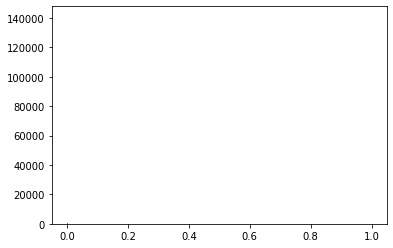

In [62]:
# Get predicted probabilities
print("Predicting")

# xgboost
# preds = xgb_model.predict_proba(blocked_poly)
# pairs_with_preds = blocked_pairs_raw[['id','ark1920']]
# pairs_with_preds['scores'] = preds[:,1]
# pairs_with_preds.to_csv('results_with_cleaned_bleemer.csv', index=None)

preds = logreg_model.predict_proba(blocked_poly)
pairs_with_preds = blocked_pairs_raw[['id','ark1920']]
pairs_with_preds['scores'] = preds[:,1]
pairs_with_preds.to_csv('results_with_cleaned_bleemer.csv', index=None)

plt.hist(preds[:,1], bins='auto')
plt.show()


In [63]:
print(max(preds[:,1]))

1.0


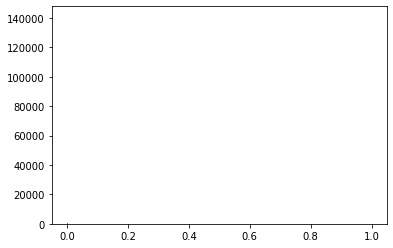

In [64]:
plt.hist(preds[:,1], bins='auto')
plt.show()